In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.stattools import medcouple
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

# set the fail rate to test
a_fail_rate = 50

# name of the output folder:
name_of_project = 'bassin_report_aare'

# set the maps
bassin_map = PILImage.open("resources/maps/aare_scaled.jpeg")
land_use_map = PILImage.open("resources/maps/land_use_aare.jpeg")

# the search term for the river bassin
bassin_name = 'aare'

lakes_of_interest = ['thunersee', 'bielersee', 'neuenburgersee']
lake_colors=["darkblue", "royalblue", "cadetblue"]

# the names for the survey area and the cumulative data
level_names = ["Aare survey area","All survey areas"]

# the scale for pieces per meter and the column and chart label for the units
reporting_unit = 50
unit_label = 'p/50m'

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# colors for gradients
colors = ['beige', 'navajowhite', 'sandybrown', 'salmon', 'sienna']
nodes = [0.0, 0.2, 0.6, 0.8, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

# get your data:
survey_data = pd.read_csv('resources/results_with_land_use_2015.csv')
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/dims_data.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# convenience function for doing land use correlations
def make_plot_with_spearmans(data, ax, n):
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    return ax, corr, a_p

# index the code data
dfCodes.set_index("code", inplace=True)

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation: includes spray foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

## Baseline values

Similar to survey results in the marine environment beach-litter-data in Switzerland is highly variable. With values ranging from zero (two surveys in 2020 had a quantity of zero), to thousands of objects and fragments within 100m coastline.

The _JRC Technical Report: A European threshold value_ {cite}`threshholdeu` suggests several methods for calculating threshold values, confidence intervals and extreme values. These values are calculated here for the survey totals and the most comon objects identified in section 2.2.4.


__Assumptions:__

*  The more trash there is on the ground the more a person is likely to find
*  **The survey results represent the minimum amount of trash at that site**
*  For each survey: finding one item does not effect the chance of finding another

In [2]:
# define the final survey data set here:
a_data = survey_data.copy()

# make a loc_date column from the survey data
# before converting to timestamp
a_data['loc_date']=tuple(zip(a_data.location, a_data.date))

# convert string dates from .csv to timestamp
a_data['date']=pd.to_datetime(a_data['date'], format='%Y-%m-%d')

# slice by start- end date
a_data = a_data[(a_data.date >= start_date)&(a_data.date <= end_date)]



# combine lugano and maggiore
# if the river bassin name does not equal tresa leave it, else change it to ticino
a_data['river_bassin'] = a_data.river_bassin.where(a_data.river_bassin != 'tresa', 'ticino' )

# assign the reporting value
a_data[unit_label] = (a_data.pcs_m * reporting_unit).round(2)

# scale the streets to kilometers
a_data['streets'] = a_data.streets.astype('int')
a_data['streets km'] = a_data.streets/1000

# save the data before aggregating to test
before_agg = a_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())

# this extracts and aggregates the members of the two code groups, returns a dataframe
the_plast_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = sut.create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
a_data = sut.replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])


### The data

Only surveys with a length greater than ten meters are included in the baseline calculation. The available space to survey in urban or suburban environments is limited, changes in the lake level and wave action can have significant effects on the available space to survey, including reducing the length of available shoreline. In IQAASL the policy was to avoid doing surveys less than ten meters. Note that this does not exclude all surveys from a location, only those that were less than ten meters.

#### Most common objects

The most common objects were identifed in section 2.2  and the properties of these objects were assessed with respect to transport and deposition in section 5. The same objects and groups are used here in the assessment of base line values.

In [3]:
# gather the dimensional data for the time frame from dfDims
# match records to survey data
fd_dims= dfDims[(dfDims.location.isin(a_data.location.unique()))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))

# map the survey area name to the dims data record
a_map = fd_dims[['loc_date', 'area']].set_index('loc_date')
l_map = fd_dims[['loc_date', 'length']].set_index('loc_date')

# map length and area from dims to survey data
for a_survey in fd_dims.loc_date.unique():
    a_data.loc[a_data.loc_date == a_survey, 'length'] = l_map.loc[[a_survey], 'length'][0]
    a_data.loc[a_data.loc_date == a_survey, 'area'] = a_map.loc[[a_survey], 'area'][0]

# exclude surveys less than 10 meters
gten_lhun = a_data.loc[(a_data.length > 10)].copy()

# this is a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

# the daily survey totals of all the data for the survey period
# a_dt = gten_lhun.groupby(['loc_date', 'date','water_name_slug'], as_index=False).agg(agg_pcs_quantity)

# survey totals by location
dt_all = gten_lhun.groupby(['loc_date','location','river_bassin', 'water_name_slug','date'], as_index=False).agg(agg_pcs_quantity)

### Identifying extreme values

The parallel use of three calculation methods, mean, median and trimean, on selected examples enabled a comparative analysis and an informed choice of a final agreed methodology among the experts in the TG ML. It was agreed to leave the extreme data in the dataset, while highlighting the need to check to verify extreme data case by case and to apply the median for calculating of averages. This allows the use of all data while not skewing results through singleextraordinary high litter count surveys.

The occurrence of extreme values can influence the average of the data and the interpretation of survey results. According the to the JRC report:

>  The methodology for the identification of extreme values can be either expert judgement, or be based on statistical and modelling approaches, such as the application of Tukey’s box plots to detect potential outliers. For skewed distributions, the adjusted box plot is more appropriate.

#### Adjusted boxplots

Tukey’s boxplot is used to visualize the distribution of a univariate data set. The samples that fall within the first quartile ($Q_1$) and the third quartile ($Q_3$) are considered to be within the innerquartial range (IQR) = $Q_3 - Q_1$. Points out side of the inner quartile range are considered outliers if their value is greater or less than one of two limits:

* lower limit = $Q_1 - (1.5*IQR)$

* upper limit = $Q_3 + (1.5*IQR)$

Adusting the boxplot involves replacing the constant 1.5 with another parameter. This parameter is calculated using a method called the _medcouple_ (MC) and applying the result of that method to the constant 1.5. {cite}`adjbox` {cite}`medcouple` The new calculation looks like this:

* lower limit = $Q_1 - (1.5e^{-4MC}*IQR)$

* upper limit = $Q_3 + (1.5e^{3MC}*IQR)$

The limit at which a survey is conisdered _extreme_ extends to the 98th percentile when the boxplots are adjusted as opposed to the 90th percentile if the constant is left at 1.5.

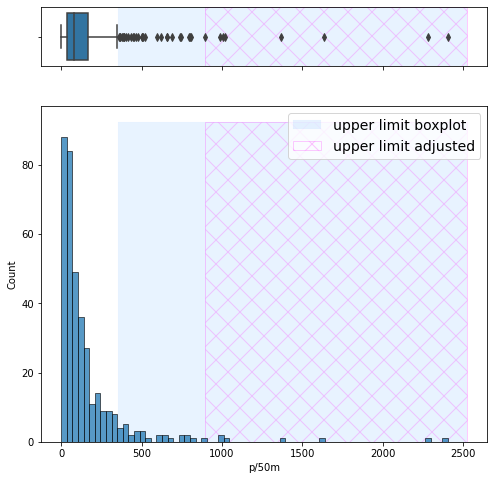

In [4]:
# implementation of medcouple
a_whis = medcouple(dt_all[unit_label].to_numpy())

# get the ecdf 
ecdf = ECDF(dt_all[unit_label].to_numpy())

# quantiles and IQR of the data
q1 = dt_all[unit_label].quantile(0.25)
q3 =dt_all[unit_label].quantile(0.75)
iqr = q3 - q1

# the upper and lower limit of extreme values unadjusted:
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr

# the upper and lower limit of extreme values adjusted:
a_fence = q1 - (1.5*(math.exp((-4*a_whis))))*iqr
a_2fence = q3 + (1.5*(math.exp((3*a_whis))))*iqr

# source = https://stackoverflow.com/questions/12127635/matplotlib-can-we-draw-a-histogram-and-a-box-plot-on-a-same-chart
fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(8,8))

# Add a graph in each part
sns.boxplot(x=dt_all[unit_label], ax=ax_box)
sns.histplot(x=dt_all[unit_label], ax=ax_hist)

# get the limits of the x and y axix
xamax = ax_hist.get_xlim()
y_max= ax_hist.get_ylim()

# no xlabel on the top axis
ax_box.set_xlabel(" ")

# fill the areas concerened by each limt
ax_hist.fill_between(x=[limit_upper,xamax[1]], y1=y_max[1], label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
ax_hist.fill_between(x=[a_2fence,xamax[1]], y1=y_max[1],label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

ax_box.fill_between(x=[limit_upper,xamax[1]], y1=ax_box.get_ylim()[1], y2=ax_box.get_ylim()[0],  label='upper limit boxplot', alpha=0.1, color="dodgerblue", linewidth=0.1)
ax_box.fill_between(x=[a_2fence,xamax[1]], y1=ax_box.get_ylim()[1], y2=ax_box.get_ylim()[0], label='upper limit adjusted', hatch='x', edgecolor='magenta', facecolor='none',alpha=0.2)

# get legend
handles, labels = ax_box.get_legend_handles_labels()
plt.legend(handles, labels, fontsize=14)

plt.show()

In [5]:
caption = F"""
*The diffrence between adjusted and normal boxplots. Adjusted = {int(a_2fence)},  unadjusted = {int(limit_upper)}.*
"""
md(caption)


*The diffrence between adjusted and normal boxplots. Adjusted = 896,  unadjusted = 354.*


#### Modeling

Extreme values can be indentified by assuming the data belong to some underlying known statistical distribution. Count data is often modeled using a poisson distribution, however this is only valid where variance is equal to the mean. The data from IQAASL and beach-litter data in general do not meet this criteria, the negative binomial (NB) distribution allows for the variance to be quadratic in the mean. {cite}`cameron` {cite}`wolfram`

> The modelling approach for the identification of extreme values is then performed by fitting the NB-distribution to the data by means of maximum likelihood and tagging all values in the right tail as potentially extreme values if the probability that they belong to the fitted NB-distribution is less than, e.g. 0.001. {cite}`threshholdeu`


##### NB method of moments

Fitting the NB distribution has all to do with estimating parameters. Alot of research has gone into estimating the dispersion parameter k of the NB distribution {cite}`mlenb`. One way to estimate the shape of the underlying distribution or dispersion, is to relate the mean to the variance. {cite}`nbinom`

*Estimating the parameters of the underlying NB distribution using the mean and the variance from the observed values*

*implementation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html*

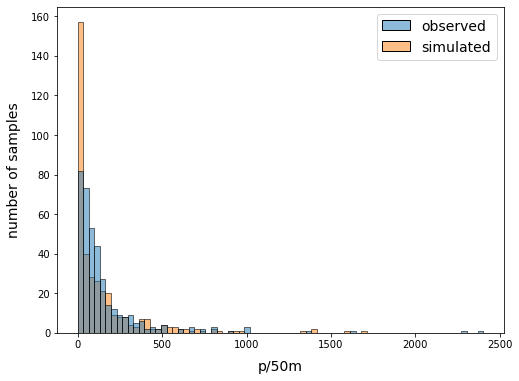

In [6]:
# the data to model
vals = dt_all[unit_label].to_numpy()

# the variance
var = np.var(vals)

# the average
mean = np.mean(vals)

# dispersion
p = mean/var
n = mean**2/(var-mean)

# point estimates from for the 98 and 90 %ile
rv = stats.nbinom(n, p)
sim_98 = rv.ppf(.98)
obs_98 = np.quantile(vals, .98)

sim_90 = rv.ppf(.9)
obs_90 = np.quantile(vals, .9)

# simulated data
r = stats.nbinom.rvs(n,p, size=len(vals))

fig, ax = plt.subplots(figsize=(8,6))

df = pd.DataFrame({unit_label:vals, 'group':'observed'})
df = df.append(pd.DataFrame({unit_label:r, 'group':'simulated'}))

sns.histplot(data=df, x=unit_label, hue='group', ax=ax, stat='count')

ax.set_xlabel(unit_label, **ck.xlab_k14)
ax.set_ylabel('number of samples', **ck.xlab_k14)

legend = ax.get_legend()
handles = legend.legendHandles
labels = [legend.texts[i].get_text() for i in [0,1]]

plt.legend(handles, labels, fontsize=14)

plt.show()

In [7]:
caption = F"""
*Point estimate of the 98th percentile from simulated data = {int(sim_98)}, estimate of the 90th percentile = {int(sim_90)}*
"""
md(caption)


*Point estimate of the 98th percentile from simulated data = 967, estimate of the 90th percentile = 448*


##### NB parameter modeling

In [8]:

import numpy as np
from scipy.special import gammaln
from scipy.special import psi
from scipy.special import factorial
from scipy.optimize import fmin_l_bfgs_b as optim

import sys


# X is a numpy array representing the data
# initial params is a numpy array representing the initial values of
# size and prob parameters
def fit_nbinom(X, initial_params=None):
    infinitesimal = np.finfo(np.float).eps

    def log_likelihood(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        #MLE estimate based on the formula on Wikipedia:
        # http://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation
        result = np.sum(gammaln(X + r)) \
            - np.sum(np.log(factorial(X))) \
            - N*(gammaln(r)) \
            + N*r*np.log(p) \
            + np.sum(X*np.log(1-(p if p < 1 else 1-infinitesimal)))

        return -result

    def log_likelihood_deriv(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        pderiv = (N*r)/p - np.sum(X)/(1-(p if p < 1 else 1-infinitesimal))
        rderiv = np.sum(psi(X + r)) \
            - N*psi(r) \
            + N*np.log(p)

        return np.array([-rderiv, -pderiv])

    if initial_params is None:
        #reasonable initial values (from fitdistr function in R)
        m = np.mean(X)
        v = np.var(X)
        size = (m**2)/(v-m) if v > m else 10

        #convert mu/size parameterization to prob/size
        p0 = size / ((size+m) if size+m != 0 else 1)
        r0 = size
        initial_params = np.array([r0, p0])

    bounds = [(infinitesimal, None), (infinitesimal, 1)]
    optimres = optim(log_likelihood,
                     x0=initial_params,
                     #fprime=log_likelihood_deriv,
                     args=(X,),
                     approx_grad=1,
                     bounds=bounds)

    params = optimres[0]
    return {'size': params[0], 'prob': params[1]}

In [9]:
fit_nbinom(vals)

/tmp/ipykernel_30622/3282365157.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  infinitesimal = np.finfo(np.float).eps
/home/mwshovel/anaconda3/envs/iqaasl/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


{'size': 0.3862005078668744, 'prob': 0.0024450669860689046}

In [10]:
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize

def log_likelihood(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        #MLE estimate based on the formula on Wikipedia:
        # http://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation
        result = np.sum(gammaln(X + r)) \
            - np.sum(np.log(factorial(X))) \
            - N*(gammaln(r)) \
            + N*r*np.log(p) \
            + np.sum(X*np.log(1-(p if p < 1 else 1-infinitesimal)))

        return -result


In [11]:
res

NameError: name 'res' is not defined

### Confidence intervals

The uncertainty of litter monitoring data used for deriving the percentile value of beach litter abundances is approximated through  the  calculation  of  confidence intervals. A minimum number of 40 surveys for a beach litter TV assessment is  recommended, because the addition of more surveys beyond this number provides only a limited gain in the improvement of the confidence interval.

#### Bootstrap methods:

There are several computational methods to choose from. percentile, BCa, and Student's t to name a few. For this project the most important aspects are computational efficiency and the correct coverage of the confidence interval. {cite}`bsci` 

#### Thresholds

Considering uncertainties of data and the resulting confidence intervals, the resulting threshold value can be considered as reached statistically, __if the lower 95% confidence limit of the aggregated monitoring values touches the upper 95% confidence limit of the 10th percentile__ of the baseline data. At this point, the assessment value and threshold value are not significantly differentany more(Cummings et al., 2006).

### Discussion

This first-timeanalysis of a harmonised EU beach litter dataset allows numerous conclusions. These apply to the process and methodology for monitoring and baseline setting, the outcome from the scenario analysis based on the selection of parameters, i.e. the agreed baseline and the policy implications of the baselines.

These implications include the selection and prioritisation of measures, the setting of thresholds and the evaluation of the success of implemented measures.

* Data availability 2012-2016 allows the consideration of all EU regions, though with different coverage. All subregions, except for the Eastern Mediterranean Sea,can be evaluated.

* Litter aggregate groups can be analysed across Europe.

* Litter  category  analyses  are  possible  from  single  beaches at different  data  aggregation  levels (depending on the comparability of litter categories between surveys)

#### Weighting data

Following discussion during the TG ML annual meeting 2019 and a consultation with TGML experts, it was concluded not to apply weighting to the beach litter survey results when aggregating them. While spatial weighting might be used for other purposes, it would not provide a benefit for assessing the environmental status on the beaches.

#### Number of samples

This corresponds to a median assessment value of approxmately  20,  for  a  range  of 40  to 100  assessment surveys. A similar statistical method is used in  the TV proposalfor plastics in fulmar stomachs (Van Franeker et al., 2019). See Annex 3 for more detailson the calculation of the confidence intervals.

#### Quality people = quality data



#### Objective criteria, protocols and analysis



In [ ]:
# source :http://www.jtrive.com/the-empirical-bootstrap-for-confidence-intervals-in-python.html

def bootstrap(data, n=1000, func=np.mean):
    """
    Generate `n` bootstrap samples, evaluating `func`
    at each resampling. `bootstrap` returns a function,
    which can be called to obtain confidence intervals
    of interest.
    """
    simulations = list()
    sample_size = len(data)
    xbar_init = np.mean(data)
    for c in range(n):
        itersample = np.random.choice(data, size=sample_size, replace=True)
        simulations.append(func(itersample))
    simulations.sort()
    def ci(p):
        """
        Return 2-sided symmetric confidence interval specified
        by p.
        """
        u_pval = (1+p)/2.
        l_pval = (1-u_pval)
        l_indx = int(np.floor(n*l_pval))
        u_indx = int(np.floor(n*u_pval))
        return(simulations[l_indx],simulations[u_indx])
    return(ci)

ci = bootstrap(dt_all['p/50m'].to_numpy(), 100)

# print(dt_all['p/50m'].median())

# for i in [.15,.25, .5, .95]:
#     print(ci(i))

In [ ]:
# source: http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2019a/content/recitations/bootstrapping.html

def draw_bs_sample(data):
    """Draw a bootstrap sample from a 1D data set."""
    return np.random.choice(data, size=len(data))

def compute_jackknife_reps(data, statfunction=np.mean):
    '''Returns jackknife resampled replicates for the given data and statistical function'''
    # Set up empty array to store jackknife replicates
    jack_reps = np.empty(len(data))

    # For each observation in the dataset, compute the statistical function on the sample
    # with that observation removed
    for i in range(len(data)):
        jack_sample = np.delete(data, i)
        jack_reps[i] = statfunction(jack_sample)
    return jack_reps


def compute_a(jack_reps):
    '''Returns the acceleration constant a'''
    mean = np.mean(jack_reps)
    return (1/6) * np.divide(np.sum(mean - jack_reps)**3, (np.sum(mean - jack_reps)**2)**(3/2))


def bootstrap_replicates(data, n_reps=1000, statfunction=np.mean):
    '''Computes n_reps number of bootstrap replicates for given data and statistical function'''
    boot_reps = np.empty(n_reps)
    for i in range(n_reps):
        boot_reps[i] = statfunction(draw_bs_sample(data))
    return boot_reps


def compute_z0(data, boot_reps, statfunction=np.mean):
    '''Computes z0 for given data and statistical function'''
    s = statfunction(data)
    return stats.norm.ppf(np.sum(boot_reps < s) / len(boot_reps))


def compute_bca_ci(data, alpha_level, n_reps=1000, statfunction=np.mean):
    '''Returns BCa confidence interval for given data at given alpha level'''
    # Compute bootstrap and jackknife replicates
    boot_reps = bootstrap_replicates(data, n_reps, statfunction)
    jack_reps = compute_jackknife_reps(data, statfunction)

    # Compute a and z0
    a = compute_a(jack_reps)
    z0 = compute_z0(data, boot_reps, statfunction)

    # Compute confidence interval indices
    alphas = np.array([alpha_level/2., 1-alpha_level/2.])
    zs = z0 + stats.norm.ppf(alphas).reshape(alphas.shape+(1,)*z0.ndim)
    avals = stats.norm.cdf(z0 + zs/(1-a*zs))
    ints = np.round((len(boot_reps)-1)*avals)
    ints = np.nan_to_num(ints).astype('int')

    # Compute confidence interval
    boot_reps = np.sort(boot_reps)
    ci_low = boot_reps[ints[0]]
    ci_high = boot_reps[ints[1]]
    return (ci_low, ci_high)



In [ ]:
author = "roger@hammerdirt.ch"
my_message = "Love what you do. \u2764\ufe0f"
md(F"""
**This project was made possible by the Swiss federal office for the environment.**<br>

>{my_message}<br>

*{author}* pushed the run button on {today}.<br>
This document originates from https://github.com/hammerdirt-analyst/IQAASL-End-0f-Sampling-2021 all copyrights apply.<br>
""")